# Configuration

## Modules

In [59]:
import pandas as pd
import seaborn as sb
import nltk
from scipy import stats
from scipy.stats import pearsonr
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string
import gensim
from gensim import corpora
from gensim.models import CoherenceModel 
import matplotlib.pyplot as plt
%matplotlib inline
nltk.download('stopwords')
nltk.download('wordnet')


!pip install pyLDAvis
import pyLDAvis
from pyLDAvis import gensim_models


import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Constants

In [60]:
INPUT_FILE = '/content/drive/MyDrive/MA5851_A3/scrape_results.csv'
TEXT_COLUMN ="Bag Of Words"
STOP_WORDS = stopwords.words('english')
EXTENDED_STOP_WORDS = ['m','u','also','est','span','a','n','said','time','one'] 
EXCLUDE_CHARACTERS = set(string.punctuation)
TOKENIZER_FUNCTION = WordNetLemmatizer().lemmatize
NUM_TOPICS=12
PASSES=50
MINIMUM_PROBABILITY=0.0
#Set bigram, trigram, etc
GRAM_N = 2
DELIMITER = b' '
NUM_TOPICS = [3,5,7]
ALPHA = 0.1

## File Storage

In [61]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Functions

In [62]:
def Clean(doc, tokenizer, exclude, stop):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(tokenizer(word) for word in punc_free.split())
    return normalized

In [63]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc = True))  # deacc = True removes punctuations

In [64]:
def Make_Ngrams(texts, gram_mod):
    return [gram_mod[doc] for doc in texts]

In [65]:
def Get_Tuple_Value(tup: tuple, x: int):
  return tup[x]

In [66]:
def Filter_By_P_Value(coef, p_values, alpha):
      output = coef.copy(deep =True)
      for column in p_values:
        for i, j in p_values[column].items():
            if j > alpha:
              output.loc[i, column] = float("NaN")
      return output

def Add_P_Value_Markers(coef, p_values, alpha, character):
      output = coef.copy(deep =True)
      for column in p_values:
        for i, j in p_values[column].items():
            if j < alpha:
              output.loc[i, column] = str(coef.loc[i, column].round(decimals = 6)) + character
            else:
                output.loc[i, column] = coef.loc[i, column]
      return output

def Pearsonr_Pval(x,y):
        return stats.pearsonr(x,y)[1]

# Execute

## Topic Modelling

In [67]:
data = pd.read_csv(INPUT_FILE)
len(data)

144

In [68]:
%%capture
#Select list of documents from data 
STOP_WORDS.extend(EXTENDED_STOP_WORDS)
doc_complete = data[TEXT_COLUMN]
# String cleaning
doc_clean = [Clean(doc, tokenizer=TOKENIZER_FUNCTION,exclude=EXCLUDE_CHARACTERS,stop=set(STOP_WORDS)).split() for doc in doc_complete]

#Make Ngrams
words = sent_to_words(doc_clean)
gram_mod = gensim.models.Phrases(words, min_count=GRAM_N, delimiter=DELIMITER)
ngrams = Make_Ngrams(doc_clean, gram_mod)

# Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
dictionary = corpora.Dictionary(ngrams)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in ngrams]

# Creating the object for LDA model using gensim library
Lda = gensim.models.ldamodel.LdaModel

corpus = [dictionary.doc2bow(text) for text in ngrams]


In [69]:
%%capture
max_coherence = 0
optimal_n_topics = 0
perplexity_scores = []
coherence_scores = []
for n in NUM_TOPICS:
  ldamodel = Lda(doc_term_matrix, num_topics=n, id2word = dictionary, passes=PASSES, minimum_probability=MINIMUM_PROBABILITY)
  perplexity = ldamodel.log_perplexity(corpus)
  coherence = CoherenceModel(model=ldamodel, texts=ngrams, dictionary=dictionary, coherence='c_v').get_coherence()
  perplexity_scores.append(perplexity)
  coherence_scores.append(coherence)
  if coherence > max_coherence:
    max_coherences = coherence
    optimal_n_topics = n
ldamodel = Lda(doc_term_matrix, num_topics=optimal_n_topics, id2word = dictionary, passes=PASSES, minimum_probability=MINIMUM_PROBABILITY)

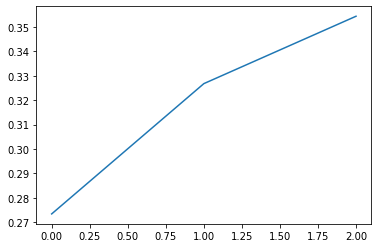

In [70]:
plt.plot(coherence_scores)

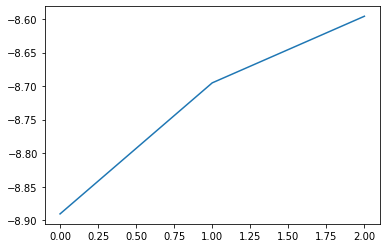

In [71]:
plt.plot(perplexity_scores)

In [72]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(ldamodel, corpus, dictionary)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.326684 -0.038171       1        1  26.774448
0     -0.073147 -0.091360       2        1  20.857596
4     -0.017276  0.207311       3        1  15.733543
6     -0.094195 -0.087563       4        1  10.680252
3     -0.030395 -0.060949       5        1   9.625575
1     -0.037573  0.123450       6        1   8.403875
2     -0.074098 -0.052719       7        1   7.924711, topic_info=          Term        Freq       Total Category  logprob  loglift
7016         n  246.000000  246.000000  Default  30.0000  30.0000
510     police  845.000000  845.000000  Default  29.0000  29.0000
3112   covid19  516.000000  516.000000  Default  28.0000  28.0000
9678     jones  133.000000  133.000000  Default  27.0000  27.0000
12382   arbery  177.000000  177.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
334        gmt   23.111923  251.564900   Topic7  -6.3473   0.1478
985     people   26.246817  847.502479   Topic7  -6.2201  -0.9396
308      first   22.980651  263.759692   Topic7  -6.3530   0.0948
689       week   21.347543  197.267767   Topic7  -6.4267   0.3116
715       year   21.347495  244.967320   Topic7  -6.4267   0.0950

[499 rows x 6 columns], token_table=      Topic      Freq Term
term                      
8         1  0.145677   12
8         2  0.280949   12
8         3  0.072839   12
8         4  0.062433   12
8         5  0.062433   12
...     ...       ...  ...
2488      3  0.255399    –
2488      4  0.020934    –
2488      5  0.142354    –
2488      6  0.146541    –
2488      7  0.066990    –

[1055 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 1, 5, 7, 4, 2, 3])

In [73]:
topics = pd.DataFrame(ldamodel[corpus])
topics = topics.applymap(lambda x: Get_Tuple_Value(x,1))

In [74]:
topics.columns= pd.DataFrame(ldamodel.print_topics(num_topics = optimal_n_topics, num_words = 3))[1]

## Sentiment Analysis

In [75]:
vader = SentimentIntensityAnalyzer()
sentiment_scores = []
for doc in doc_complete:
  sentiment_scores.append(vader.polarity_scores(doc))

In [76]:
sentiments = pd.DataFrame(sentiment_scores)

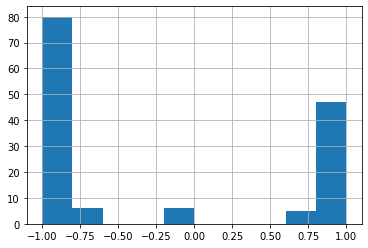

In [77]:
sentiments['compound'].hist()

## Regression Analysis

In [78]:
regression_analysis_data = pd.concat([topics,sentiments], axis = 1)
len(regression_analysis_data)

144

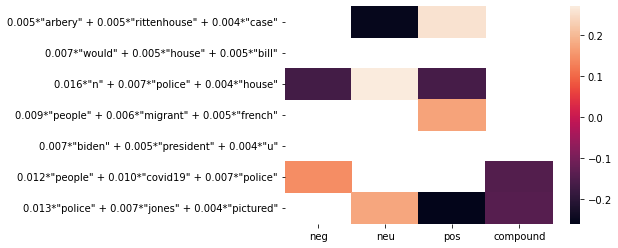

In [79]:
sentiment_variables = ["neg","neu","pos","compound"]
corr = regression_analysis_data.corr()
p_values = regression_analysis_data.corr(method = Pearsonr_Pval)
vis_data = Filter_By_P_Value(corr,p_values,ALPHA)
sb.heatmap(vis_data.loc[:,sentiment_variables].drop(sentiment_variables, axis = 0))